# CelebA Training with Distance Weight

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import random
import pickle

import torch
import torch.nn as nn
import torch.optim as optim

# created library
import mydata
from mymodels import TransDataset, LoadDataset, VGG16Model, ResNet50Model, EfficientB7Model

In [2]:
# to reproduce

seed = 42
random.seed(seed) #　ほかのモジュールで使われているかも
np.random.seed(seed) # ほかのモジュールで使われているかも
torch.manual_seed(seed) # Pytorchの中のシード
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True # GPUの計算過程の変化をさせない
from distancetraining import ModelTrainer

# Efficientnet

In [3]:
db = "CelebA"
model_name = "efficientnet"
root = f"../../dataset/AAAI 2025/{db}/"
polynomial_save_file = f"{root}model/pickle/f1_{model_name}.pkl"
model_save_directory = f"{root}/novel_model/{model_name}/"
df_valid_filepath = f"../../dataset/AAAI 2025/{db}/evaluation/df_valid_{model_name}_f1.csv"
df_test_filepath = f"../../dataset/AAAI 2025/{db}/evaluation/df_test_{model_name}_f1.csv"

In [4]:
df_train = mydata.load_and_process_csv(f"{root}/dataframe/df_train.csv")
df_valid = mydata.load_and_process_csv(f"{root}/dataframe/df_valid.csv")
df_test = mydata.load_and_process_csv(f"{root}/dataframe/df_test.csv")

In [5]:
ycol="labels"
batch_size = 8 # １インプットずつペナルティを付加するため

ld = LoadDataset(df_train, df_valid, df_test, ycol, batch_size)
train_loader, valid_loader, test_loader = ld.create_dataloaders()

H*W:  (218, 178)


Validation Accuracy: 0.4916 | Loss: 0.6824 | F1: 0.0000 | AUC: 0.6237
Validation Accuracy: 0.4916 | Loss: 0.6674 | F1: 0.0000 | AUC: 0.7333
Validation Accuracy: 0.5009 | Loss: 0.6460 | F1: 0.0362 | AUC: 0.8173
Validation Accuracy: 0.5759 | Loss: 0.6143 | F1: 0.2846 | AUC: 0.8699
Validation Accuracy: 0.6687 | Loss: 0.5690 | F1: 0.5187 | AUC: 0.9020
Validation Accuracy: 0.7306 | Loss: 0.5123 | F1: 0.6426 | AUC: 0.9186
Validation Accuracy: 0.7465 | Loss: 0.4725 | F1: 0.6703 | AUC: 0.9251
Validation Accuracy: 0.7648 | Loss: 0.4340 | F1: 0.7015 | AUC: 0.9312
Validation Accuracy: 0.7826 | Loss: 0.4043 | F1: 0.7302 | AUC: 0.9369
Validation Accuracy: 0.8102 | Loss: 0.3800 | F1: 0.7729 | AUC: 0.9409
Validation Accuracy: 0.8182 | Loss: 0.3653 | F1: 0.7847 | AUC: 0.9443
Validation Accuracy: 0.8365 | Loss: 0.3456 | F1: 0.8112 | AUC: 0.9494
Validation Accuracy: 0.8369 | Loss: 0.3376 | F1: 0.8119 | AUC: 0.9504
Validation Accuracy: 0.8575 | Loss: 0.3169 | F1: 0.8400 | AUC: 0.9552
Validation Accuracy:

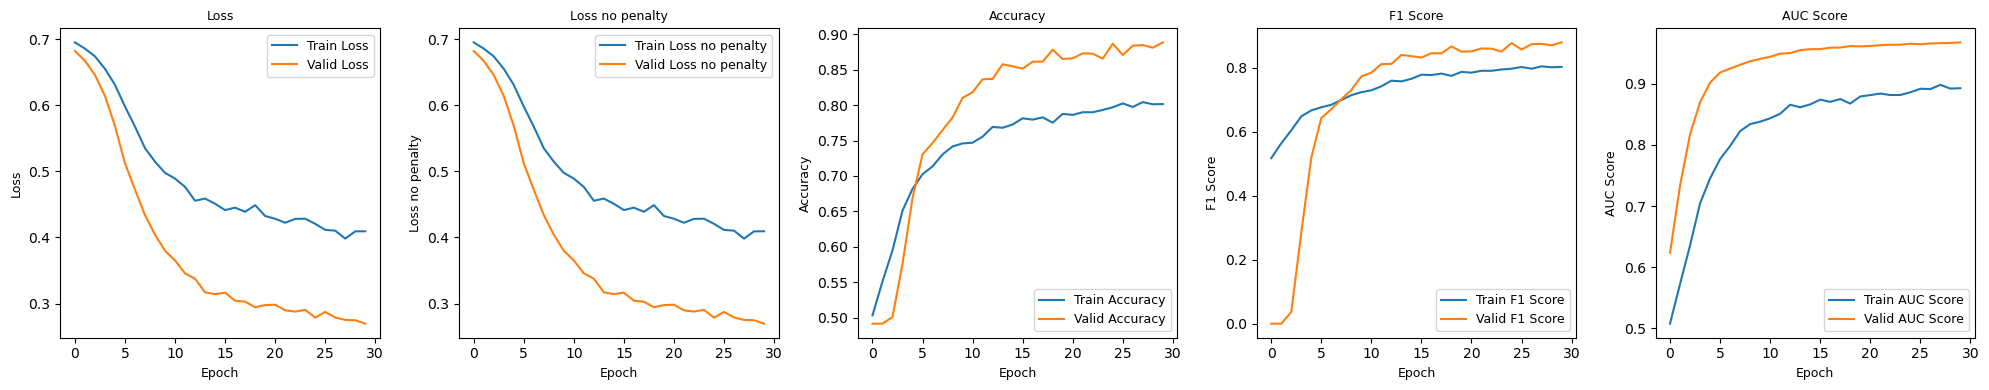

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EfficientB7Model().to(device) # model -> GPU

# Load model
with open(polynomial_save_file, "rb") as f:
    polynomial_model = pickle.load(f)

num_epochs = 30
lr = 1e-6
start = 17
trainer = ModelTrainer(polynomial_model, model_save_directory)
best_val_file = trainer.train(model, train_loader, valid_loader, start, num_epochs=num_epochs, lr=lr)

In [7]:
def evaluations(trainer, model, valid_loader, df, df_filepath):
    test_predictions, test_outputs = trainer.evaluate(model, valid_loader)
    tmp = df.copy()
    tmp["predictions"] = test_predictions
    tmp["proba"] = test_outputs
    tmp.to_csv(df_filepath, index=False)
    trainer.report(tmp)

In [8]:
model = EfficientB7Model().to(device) # model -> GPU
model.load_state_dict(torch.load(best_val_file))
evaluations(trainer, model, valid_loader, df_valid, df_valid_filepath)

              precision    recall  f1-score   support

           0       0.87      0.96      0.91      1049
           1       0.95      0.86      0.90      1085

    accuracy                           0.91      2134
   macro avg       0.91      0.91      0.91      2134
weighted avg       0.91      0.91      0.91      2134

Skin tone 1: Accuracy 0.9081537019681349
Skin tone 2: Accuracy 0.9062792877225867


In [9]:
evaluations(trainer, model, test_loader, df_test, df_test_filepath)

              precision    recall  f1-score   support

           0       0.87      0.94      0.91      1047
           1       0.94      0.87      0.90      1082

    accuracy                           0.90      2129
   macro avg       0.91      0.90      0.90      2129
weighted avg       0.91      0.90      0.90      2129

Skin tone 2: Accuracy 0.898886827458256
Skin tone 1: Accuracy 0.9086584205518554


# Resnet

In [10]:
model_name = "resnet"
root = f"../../dataset/AAAI 2025/{db}/"
polynomial_save_file = f"{root}model/pickle/f1_{model_name}.pkl"
model_save_directory = f"{root}/novel_model/{model_name}/"
df_valid_filepath = f"../../dataset/AAAI 2025/{db}/evaluation/df_valid_{model_name}_f1.csv"
df_test_filepath = f"../../dataset/AAAI 2025/{db}/evaluation/df_test_{model_name}_f1.csv"

/home/kuniko/anaconda3/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
/home/kuniko/anaconda3/lib/python3.11/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Validation Accuracy: 0.4916 | Loss: 0.6919 | F1: 0.0000 | AUC: 0.5303
Validation Accuracy: 0.4916 | Loss: 0.6866 | F1: 0.0000 | AUC: 0.5911
Validation Accuracy: 0.4916 | Loss: 0.6849 | F1: 0.0000 | AUC: 0.6113
Validation Accuracy: 0.4916 | Loss: 0.6800 | F1: 0.0000 | AUC: 0.6570
Validation Accuracy: 0.4916 | Loss: 0.6777 | F1: 0.0000 | AUC: 0.6854
Validation Accuracy: 0.4920 | Loss: 0.6703 | F1: 0.0018 | AUC: 0.7294
Validation Accuracy: 0.4930 | Loss: 0.6609 | F1: 0.0055 | AUC: 0.7681
Validation Accuracy: 0.5103 | Loss: 0.6462 | F1: 0.0728 | AUC: 0.7967
Validation Accuracy: 0.5703 | Loss: 0.6253 | F1: 0.2774 | AUC: 0.8378
Validation Accuracy: 0.6701 | Loss: 0.5754 | F1: 0.5275 | AUC: 0.8732
Validation Accuracy: 0.6640 | Loss: 0.5552 | F1: 0.5152 | AUC: 0.8775
Validation Accuracy: 0.7413 | Loss: 0.4891 | F1: 0.6675 | AUC: 0.8987
Validation Accuracy: 0.7601 | Loss: 0.4466 | F1: 0.6999 | AUC: 0.9090
Validation Accuracy: 0.7605 | Loss: 0.4345 | F1: 0.6975 | AUC: 0.9055
Validation Accuracy:

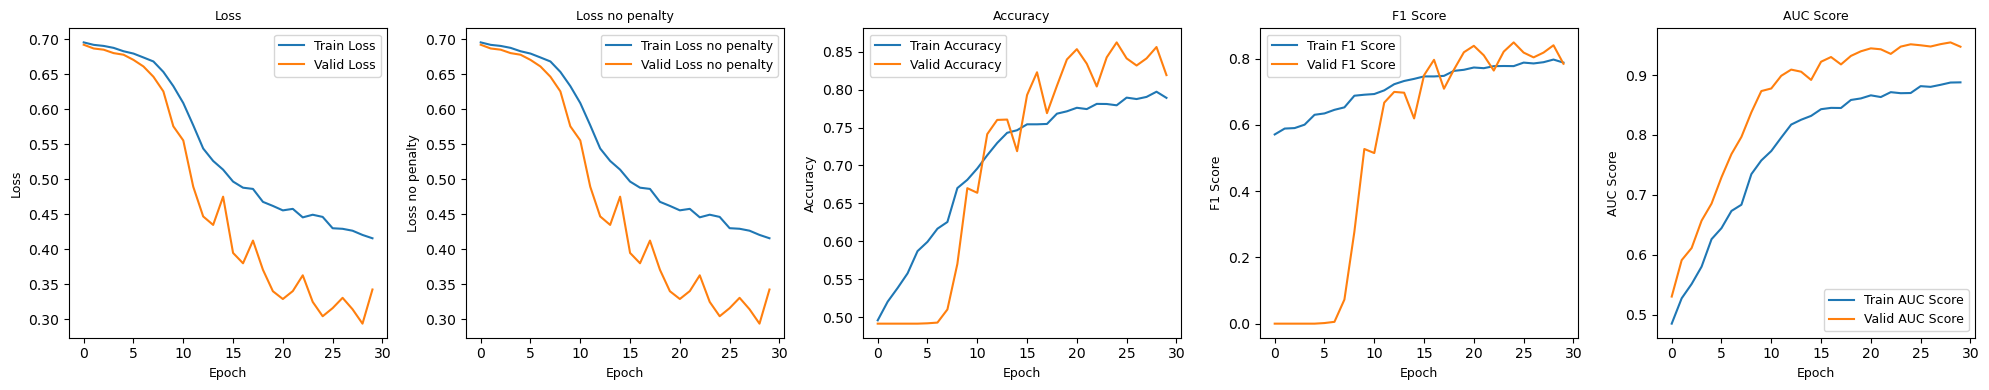

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet50Model().to(device) # model -> GPU

# Load model
with open(polynomial_save_file, "rb") as f:
    polynomial_model = pickle.load(f)

num_epochs = 30
lr = 1e-6
start = 17
trainer = ModelTrainer(polynomial_model, model_save_directory)
best_val_file = trainer.train(model, train_loader, valid_loader, start, num_epochs=num_epochs, lr=lr)

In [12]:
model = ResNet50Model().to(device) # model -> GPU
model.load_state_dict(torch.load(best_val_file))
evaluations(trainer, model, valid_loader, df_valid, df_valid_filepath)

              precision    recall  f1-score   support

           0       0.83      0.95      0.89      1049
           1       0.94      0.82      0.87      1085

    accuracy                           0.88      2134
   macro avg       0.89      0.88      0.88      2134
weighted avg       0.89      0.88      0.88      2134

Skin tone 1: Accuracy 0.8837863167760075
Skin tone 2: Accuracy 0.8772258669165885


In [13]:
evaluations(trainer, model, test_loader, df_test, df_test_filepath)

              precision    recall  f1-score   support

           0       0.83      0.94      0.88      1047
           1       0.93      0.81      0.86      1082

    accuracy                           0.87      2129
   macro avg       0.88      0.87      0.87      2129
weighted avg       0.88      0.87      0.87      2129

Skin tone 2: Accuracy 0.8664192949907236
Skin tone 1: Accuracy 0.8763082778306375


# VGG

In [14]:
model_name = "vgg"
root = f"../../dataset/AAAI 2025/{db}/"
polynomial_save_file = f"{root}model/pickle/f1_{model_name}.pkl"
model_save_directory = f"{root}/novel_model/{model_name}/"
df_valid_filepath = f"../../dataset/AAAI 2025/{db}/evaluation/df_valid_{model_name}_f1.csv"
df_test_filepath = f"../../dataset/AAAI 2025/{db}/evaluation/df_test_{model_name}_f1.csv"

/home/kuniko/anaconda3/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
/home/kuniko/anaconda3/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Validation Accuracy: 0.5497 | Loss: 0.6537 | F1: 0.2281 | AUC: 0.7483
Validation Accuracy: 0.7718 | Loss: 0.5302 | F1: 0.7386 | AUC: 0.8735
Validation Accuracy: 0.8261 | Loss: 0.4234 | F1: 0.8277 | AUC: 0.9102
Validation Accuracy: 0.8486 | Loss: 0.3655 | F1: 0.8493 | AUC: 0.9275
Validation Accuracy: 0.8543 | Loss: 0.3286 | F1: 0.8461 | AUC: 0.9363
Validation Accuracy: 0.8693 | Loss: 0.3249 | F1: 0.8677 | AUC: 0.9431
Validation Accuracy: 0.8763 | Loss: 0.2966 | F1: 0.8723 | AUC: 0.9497
Validation Accuracy: 0.8693 | Loss: 0.2820 | F1: 0.8599 | AUC: 0.9537
Validation Accuracy: 0.8725 | Loss: 0.2689 | F1: 0.8635 | AUC: 0.9581
Validation Accuracy: 0.8655 | Loss: 0.2707 | F1: 0.8520 | AUC: 0.9597
Validation Accuracy: 0.8875 | Loss: 0.2534 | F1: 0.8821 | AUC: 0.9620
Validation Accuracy: 0.8866 | Loss: 0.2455 | F1: 0.8803 | AUC: 0.9640
Validation Accuracy: 0.9016 | Loss: 0.2474 | F1: 0.9004 | AUC: 0.9649
Validation Accuracy: 0.8880 | Loss: 0.2400 | F1: 0.8820 | AUC: 0.9658
Validation Accuracy:

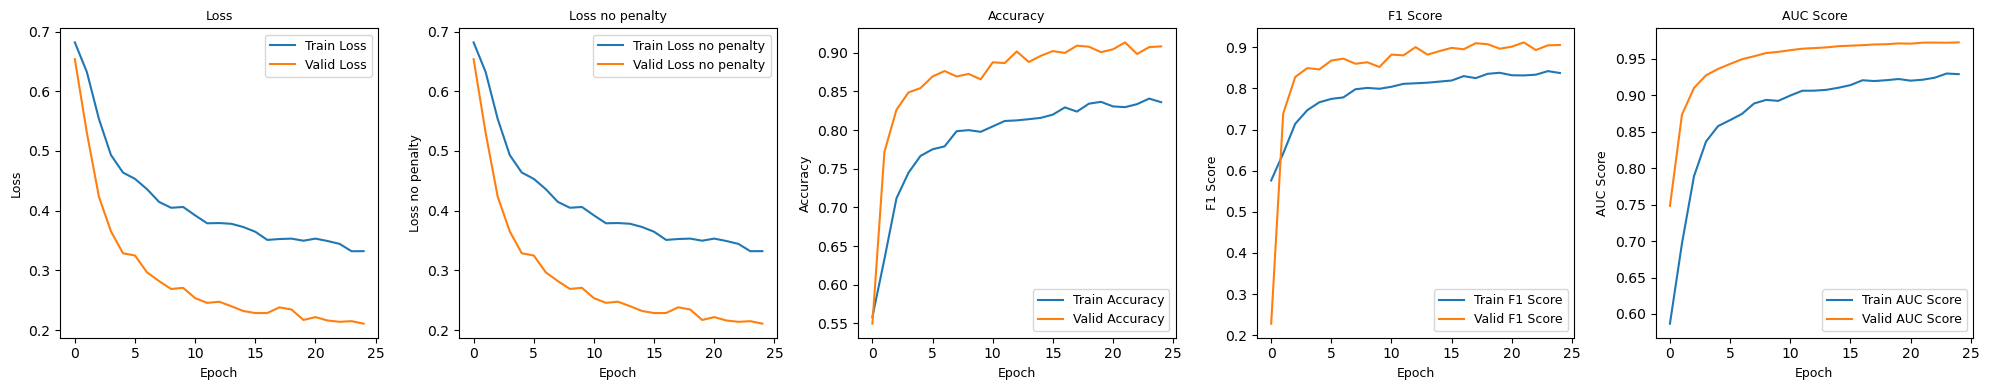

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VGG16Model().to(device) # model -> GPU

# Load model
with open(polynomial_save_file, "rb") as f:
    polynomial_model = pickle.load(f)

num_epochs = 25
lr = 1e-6
start = 17
trainer = ModelTrainer(polynomial_model, model_save_directory)
best_val_file = trainer.train(model, train_loader, valid_loader, start, num_epochs=num_epochs, lr=lr)

In [16]:
model = VGG16Model().to(device) # model -> GPU
model.load_state_dict(torch.load(best_val_file))
evaluations(trainer, model, valid_loader, df_valid, df_valid_filepath)

              precision    recall  f1-score   support

           0       0.91      0.92      0.92      1049
           1       0.92      0.91      0.92      1085

    accuracy                           0.92      2134
   macro avg       0.92      0.92      0.92      2134
weighted avg       0.92      0.92      0.92      2134

Skin tone 1: Accuracy 0.936269915651359
Skin tone 2: Accuracy 0.8959700093720713


In [17]:
evaluations(trainer, model, test_loader, df_test, df_test_filepath)

              precision    recall  f1-score   support

           0       0.90      0.90      0.90      1047
           1       0.91      0.90      0.90      1082

    accuracy                           0.90      2129
   macro avg       0.90      0.90      0.90      2129
weighted avg       0.90      0.90      0.90      2129

Skin tone 2: Accuracy 0.885899814471243
Skin tone 1: Accuracy 0.9210275927687916
